# Try Iterative control policy

In [1]:
import numpy as np
from stabnode.node import (
    FeluSigmoidMLP,
    GeluSigmoidMLP,
    StabNODE
)

from data.tanks import two_tank_system
from scipy.integrate import solve_ivp as sp_solve_ivp
import torchode

import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'

device = 'cpu'

$$
\mathcal{R}(u)\triangleq g_{\text{NODE}}^K(x_{\text{init}},u) - x_{\text{target}}
$$
$$
u_{n+1} = u_{n} - \eta \nabla \mathcal{R}(u_n)
$$

In [2]:
model_path = "batch_50/model_opt_states.pt"

f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=0, upper_bound=1)
model = StabNODE(f,g).to(device)

config = torch.load(model_path, map_location=device, weights_only=False)
f.load_state_dict(config["f_state_dict"])
g.load_state_dict(config["g_state_dict"])
model.load_state_dict(config["stabnode_state_dict"])

g_eval = g.eval()
model_eval = model.eval()

## control policy functions

In [3]:
def g_iter(x, u, max_iter):
    for _ in range(max_iter):
        x = g_eval(x, u)
    return x

def control_resid(u, x0, x1, max_iter=10):
    xi = g_iter(x0, u, max_iter)
    return x1 - xi

def control_policy(u0, x0, x1, eta, gd_steps, max_iter=10):
    u = u0.clone().detach().requires_grad_(True)
    resid_hist = []
    grad_norms = []

    for _ in range(gd_steps):
        if u.grad is not None:
            u.grad.zero_()

        resid = torch.sum(control_resid(u, x0, x1, max_iter=max_iter)**2)
        resid_hist.append(resid.item())

        resid.backward()

        with torch.no_grad():
            grad = u.grad
            grad_norms.append(torch.linalg.norm(grad).item())
            u -= eta * grad
            
        u = u.detach().requires_grad_(True)

    return u, resid_hist, grad_norms

In [5]:
eta = 1e-2
gd_steps = 200
x0 = torch.tensor([0.5,0.5],dtype=torch.float32,)
x1 = torch.tensor([0.4, 0.7],dtype=torch.float32)
u0 = torch.tensor([0.5,0.5],dtype=torch.float32,requires_grad=True)

u_control, resid_hist, norm_hist = control_policy(u0,x0,x1,eta,gd_steps=gd_steps,max_iter=10)
u_control = u_control.detach()
u_control, resid_hist[-1]

(tensor([0.4361, 0.2360]), 0.00013697925896849483)

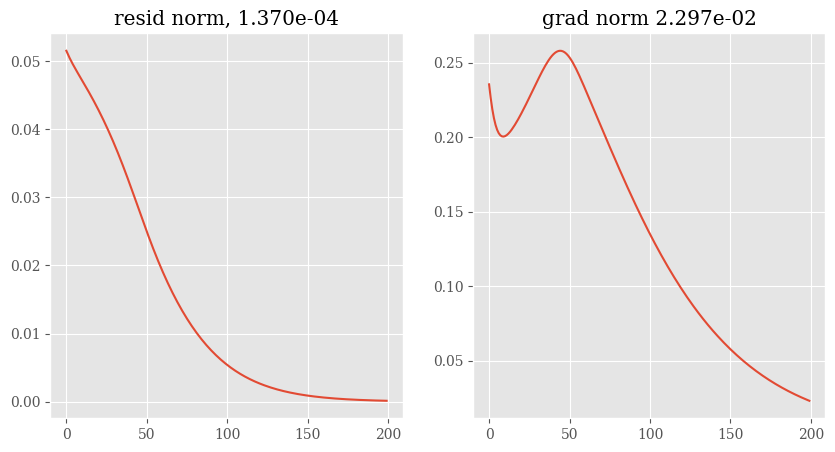

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(resid_hist)
# ax1.set_yscale('log')
ax1.set_title(f'resid norm, {resid_hist[-1]:.3e}')
ax2.plot(norm_hist)
# ax2.set_yscale('log')
ax2.set_title(f'grad norm {norm_hist[-1]:.3e}')
plt.show()

# check results

In [13]:
# Iteration prediction
max_iter = 21

with torch.no_grad():
    u0_iteration = np.array([g_iter(x0,u0, i).numpy() for i in range(0,max_iter)])


with torch.no_grad():
    u1_iteration = np.array([
        g_iter(x0,u_control,i) for i in range(0,max_iter)
    ])


# true dynamics
t_max = 200
n_colloc = 501
sol_u0 = sp_solve_ivp(
    two_tank_system,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval = np.linspace(0,t_max, n_colloc),
    args = (u0.detach().numpy(),)
)

sol_u1 = sp_solve_ivp(
    two_tank_system,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval = np.linspace(0,t_max, n_colloc),
    args = (u_control.detach().numpy(),)
)

# NODE dynamics
solve_method='tsit5'

control = lambda t: u0.detach()
func = lambda t, x: model_eval(t,x,control)

Ti = torch.linspace(0,t_max,n_colloc)

tor_sol_u0 = torchode.solve_ivp(
    f=func,
    y0=x0.view(1,-1),
    t_eval=Ti.squeeze(),
    method=solve_method
)

control = lambda t: u_control
func = lambda t, x: model_eval(t,x,control)

tor_sol_u1 = torchode.solve_ivp(
    f=func,
    y0=x0.view(1,-1),
    t_eval=Ti.squeeze(),
    method=solve_method
)

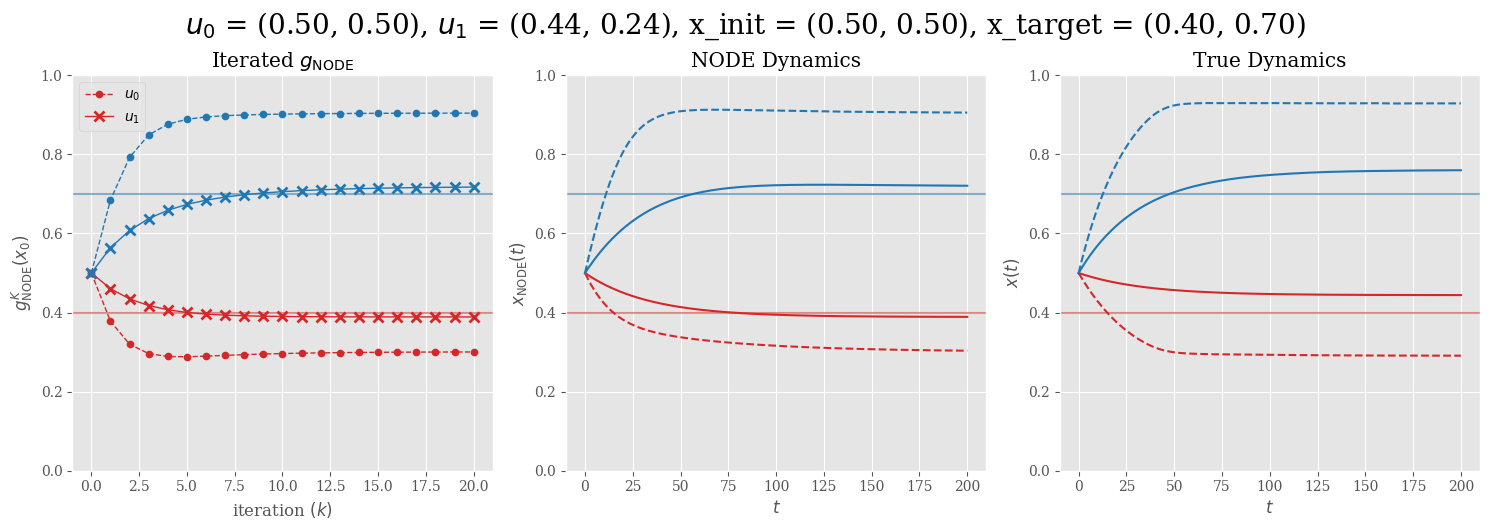

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

# Iteration
# Initial 
ax1.plot(np.arange(len(u0_iteration)),u0_iteration[:,0],linestyle='--', lw=1,          
    marker='.', markersize=7, markeredgewidth=2,label=r'$u_0$',c='tab:red')
ax1.plot(np.arange(len(u0_iteration)),u0_iteration[:,1],linestyle='--', lw=1,          
    marker='.', markersize=7, markeredgewidth=2,c='tab:blue')

# Optimized 
ax1.plot(np.arange(len(u1_iteration)),u1_iteration[:,0],linestyle='-', lw=1,          
    marker='x', markersize=7, markeredgewidth=2,label=r"$u_1$", c='tab:red')
ax1.plot(np.arange(len(u1_iteration)),u1_iteration[:,1],linestyle='-', lw=1,          
    marker='x', markersize=7, markeredgewidth=2,c='tab:blue')

ax1.axhline(x1[0], c='tab:red',alpha=0.5)
ax1.axhline(x1[1],c='tab:blue',alpha=0.5)
ax1.set_ylim(0,1)

ax1.set_title(r"Iterated $g_{\text{NODE}}$")
ax1.set_xlabel(r"iteration $(k)$")
ax1.set_ylabel(r"$g^K_{\text{NODE}}(x_0)$")
ax1.legend()

# NODE dynamics
t = tor_sol_u0.ts.squeeze().numpy()
X = tor_sol_u0.ys.squeeze().detach().numpy()
ax2.plot(t, X[:,0],linestyle='--',c='tab:red')
ax2.plot(t, X[:,1],linestyle='--',c='tab:blue')


t = tor_sol_u1.ts.squeeze().numpy()
X = tor_sol_u1.ys.squeeze().detach().numpy()
ax2.plot(t, X[:,0],linestyle='-',c='tab:red')
ax2.plot(t, X[:,1],linestyle='-',c='tab:blue')


ax2.axhline(x1[0], c='tab:red',alpha=0.5)
ax2.axhline(x1[1],c='tab:blue',alpha=0.5)
ax2.set_ylim(0,1)
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$x_{\text{NODE}}(t)$")
ax2.set_title("NODE Dynamics")

# true dynamics
ax3.plot(sol_u0.t, sol_u0.y[0,:],c="tab:red", label="tank 1",linestyle='--')
ax3.plot(sol_u0.t, sol_u0.y[1,:],c="tab:blue", label="tank 2",linestyle='--')

ax3.plot(sol_u1.t, sol_u1.y[0,:],c="tab:red", label="tank 1")
ax3.plot(sol_u1.t, sol_u1.y[1,:],c="tab:blue", label="tank 2")

ax3.axhline(x1[0], c='tab:red',alpha=0.5)
ax3.axhline(x1[1],c='tab:blue',alpha=0.5)
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$x(t)$")

ax3.set_title("True Dynamics")
ax3.set_ylim(0,1)

p0,v0 = u0.detach().numpy()
p1, v1 = u_control.detach().numpy()

x_init = x0.detach().numpy()
x_target = x1.detach().numpy()

plt.tight_layout()
plt.suptitle(
    rf"$u_0$ = ({p0:.2f}, {v0:.2f}), "
    rf"$u_1$ = ({p1:.2f}, {v1:.2f}), "
    rf"x_init = ({x_init[0]:.2f}, {x_init[1]:.2f}), "
    rf"x_target = ({x_target[0]:.2f}, {x_target[1]:.2f})",
    y=1.05,
    size=20,
)
plt.show()

# Check more Results

In [15]:
eta = 1e-2
gd_steps = 200
x0 = torch.tensor([0.5,0.5],dtype=torch.float32,)
x1 = torch.tensor([0.2, 0.8],dtype=torch.float32)
u0 = torch.tensor([0.5,0.5],dtype=torch.float32,requires_grad=True)

u_control, resid_hist, norm_hist = control_policy(u0,x0,x1,eta,gd_steps=gd_steps,max_iter=10)
u_control = u_control.detach()
u_control, resid_hist[-1]

(tensor([0.4469, 0.4859]), 1.0128853318747133e-05)

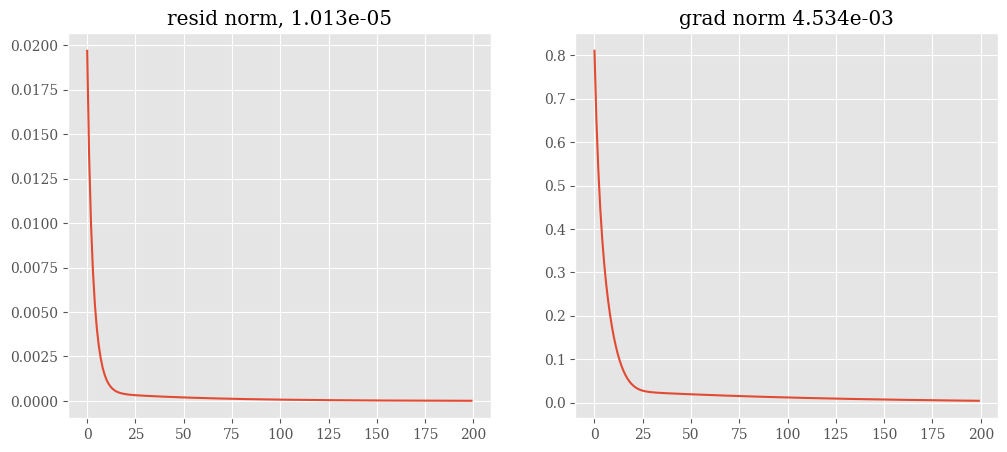

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(resid_hist)
# ax1.set_yscale('log')
ax1.set_title(f'resid norm, {resid_hist[-1]:.3e}')
ax2.plot(norm_hist)
# ax2.set_yscale('log')
ax2.set_title(f'grad norm {norm_hist[-1]:.3e}')
plt.show()

In [18]:
# Iteration prediction
max_iter = 21

with torch.no_grad():
    u0_iteration = np.array([g_iter(x0,u0, i).numpy() for i in range(0,max_iter)])


with torch.no_grad():
    u1_iteration = np.array([
        g_iter(x0,u_control,i) for i in range(0,max_iter)
    ])


# true dynamics
t_max = 200
n_colloc = 501
sol_u0 = sp_solve_ivp(
    two_tank_system,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval = np.linspace(0,t_max, n_colloc),
    args = (u0.detach().numpy(),)
)

sol_u1 = sp_solve_ivp(
    two_tank_system,
    t_span = [0,t_max],
    y0 = np.array(x0),
    t_eval = np.linspace(0,t_max, n_colloc),
    args = (u_control.detach().numpy(),)
)

# NODE dynamics
solve_method='tsit5'

control = lambda t: u0.detach()
func = lambda t, x: model_eval(t,x,control)

Ti = torch.linspace(0,t_max,n_colloc)

tor_sol_u0 = torchode.solve_ivp(
    f=func,
    y0=x0.view(1,-1),
    t_eval=Ti.squeeze(),
    method=solve_method
)

control = lambda t: u_control
func = lambda t, x: model_eval(t,x,control)

tor_sol_u1 = torchode.solve_ivp(
    f=func,
    y0=x0.view(1,-1),
    t_eval=Ti.squeeze(),
    method=solve_method
)

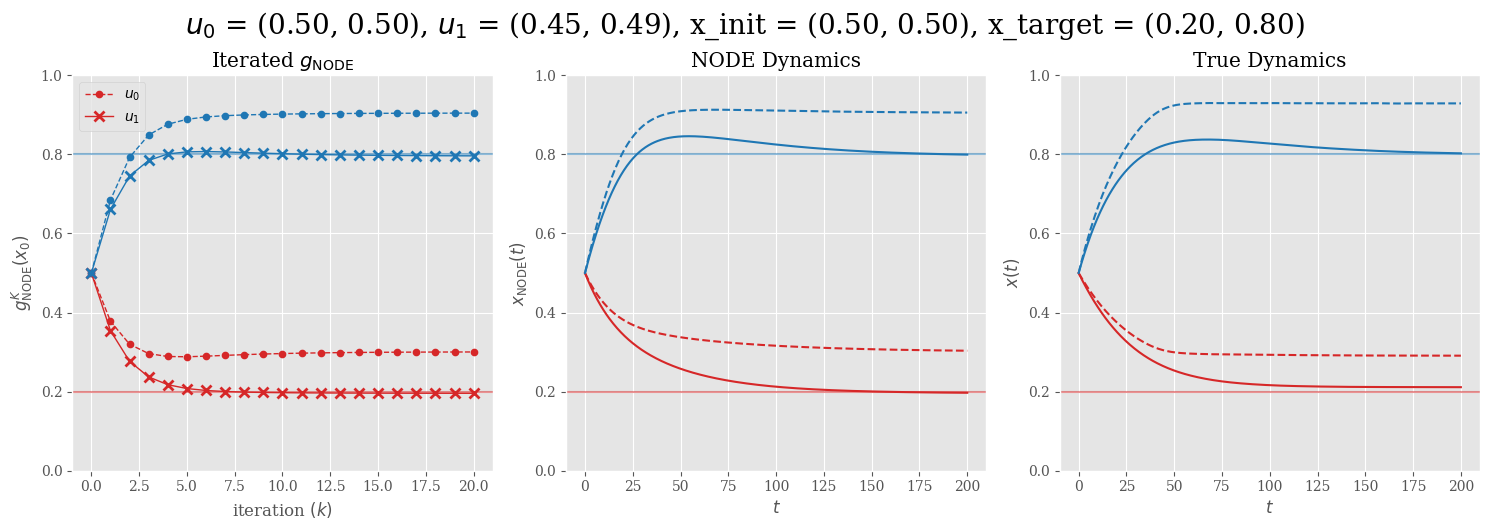

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

# Iteration
# Initial 
ax1.plot(np.arange(len(u0_iteration)),u0_iteration[:,0],linestyle='--', lw=1,          
    marker='.', markersize=7, markeredgewidth=2,label=r'$u_0$',c='tab:red')
ax1.plot(np.arange(len(u0_iteration)),u0_iteration[:,1],linestyle='--', lw=1,          
    marker='.', markersize=7, markeredgewidth=2,c='tab:blue')

# Optimized 
ax1.plot(np.arange(len(u1_iteration)),u1_iteration[:,0],linestyle='-', lw=1,          
    marker='x', markersize=7, markeredgewidth=2,label=r"$u_1$", c='tab:red')
ax1.plot(np.arange(len(u1_iteration)),u1_iteration[:,1],linestyle='-', lw=1,          
    marker='x', markersize=7, markeredgewidth=2,c='tab:blue')

ax1.axhline(x1[0], c='tab:red',alpha=0.5)
ax1.axhline(x1[1],c='tab:blue',alpha=0.5)
ax1.set_ylim(0,1)

ax1.set_title(r"Iterated $g_{\text{NODE}}$")
ax1.set_xlabel(r"iteration $(k)$")
ax1.set_ylabel(r"$g^K_{\text{NODE}}(x_0)$")
ax1.legend()

# NODE dynamics
t = tor_sol_u0.ts.squeeze().numpy()
X = tor_sol_u0.ys.squeeze().detach().numpy()
ax2.plot(t, X[:,0],linestyle='--',c='tab:red')
ax2.plot(t, X[:,1],linestyle='--',c='tab:blue')


t = tor_sol_u1.ts.squeeze().numpy()
X = tor_sol_u1.ys.squeeze().detach().numpy()
ax2.plot(t, X[:,0],linestyle='-',c='tab:red')
ax2.plot(t, X[:,1],linestyle='-',c='tab:blue')


ax2.axhline(x1[0], c='tab:red',alpha=0.5)
ax2.axhline(x1[1],c='tab:blue',alpha=0.5)
ax2.set_ylim(0,1)
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$x_{\text{NODE}}(t)$")
ax2.set_title("NODE Dynamics")

# true dynamics
ax3.plot(sol_u0.t, sol_u0.y[0,:],c="tab:red", label="tank 1",linestyle='--')
ax3.plot(sol_u0.t, sol_u0.y[1,:],c="tab:blue", label="tank 2",linestyle='--')

ax3.plot(sol_u1.t, sol_u1.y[0,:],c="tab:red", label="tank 1")
ax3.plot(sol_u1.t, sol_u1.y[1,:],c="tab:blue", label="tank 2")

ax3.axhline(x1[0], c='tab:red',alpha=0.5)
ax3.axhline(x1[1],c='tab:blue',alpha=0.5)
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$x(t)$")

ax3.set_title("True Dynamics")
ax3.set_ylim(0,1)

p0,v0 = u0.detach().numpy()
p1, v1 = u_control.detach().numpy()

x_init = x0.detach().numpy()
x_target = x1.detach().numpy()

plt.tight_layout()
plt.suptitle(
    rf"$u_0$ = ({p0:.2f}, {v0:.2f}), "
    rf"$u_1$ = ({p1:.2f}, {v1:.2f}), "
    rf"x_init = ({x_init[0]:.2f}, {x_init[1]:.2f}), "
    rf"x_target = ({x_target[0]:.2f}, {x_target[1]:.2f})",
    y=1.05,
    size=20,
)
plt.show()